In [2]:
import cv2
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import pickle
import math
import warnings
import math
warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.models import Model, load_model

### Create dataset

In [3]:
df = pd.read_csv('/data1/Itzel/id_and_label_10000.csv')

In [4]:
root_dir = '/data1/Heerlen_HR_2018/full/'

In [22]:
def path_list(df, root_dir):
    img_dirs_list = []
    for image_file in df.iloc[:,0]:
        path = root_dir + image_file
        img_dirs_list.append(path)
    return img_dirs_list

In [31]:
def get_dataset_name(file_name_with_dir):
    filename_without_dir = file_name_with_dir.split('/')[-1]
    return filename_without_dir

In [30]:
def concatenate_data(data_paths, df):
    data = []
    labels = []
    dictionary = dict(zip(df['unique_id'], df['label']))
    for path in data_paths:     
        # data
        img_matrix = cv2.imread(path)
        img_resized = cv2.resize(img_matrix, (187,187))
        data.append(img_resized)
        # labels
        img_file = get_dataset_name(path)
        lab = dictionary[img_file]
        labels.append(lab)
        
        if len(data) % 1000 == 0:
            print('{} of {} samples processed'.format(len(data), len(df)))
    return np.array(data), np.array(labels)

In [23]:
data_paths = path_list(df, root_dir)

In [24]:
len(data_paths)

10000

In [32]:
data, labels = concatenate_data(data_paths, df)

1000 of 10000 samples processed
2000 of 10000 samples processed
3000 of 10000 samples processed
4000 of 10000 samples processed
5000 of 10000 samples processed
6000 of 10000 samples processed
7000 of 10000 samples processed
8000 of 10000 samples processed
9000 of 10000 samples processed
10000 of 10000 samples processed


In [10]:
count = 0
for label in labels:
    if label == int(1):
        count = count + 1
count

4672

In [11]:
# print(data.shape)
# print(labels.shape)

#### Create the VGG16 object

In [13]:
model_path = '/data1/model.hdf5'
model = load_model(model_path)

In [14]:
# layer_names = [layer.name for layer in model.layers]

In [15]:
# layer_names

In [16]:
# int_layer_model = Model(inputs=model.input,
#                        outputs=model.get_layer('flatten_1').output)

#### Feature vectors for random sample

In [17]:
# def create_feature_list(path):
#     vgg16_feature_list = []
#     for im in path:
#         img = image.load_img(im, target_size=(187, 187))
#         img_data = image.img_to_array(img)
#         img_data = np.expand_dims(img_data, axis=0)
#         img_data = preprocess_input(img_data) # from RGB to BGR
#         vgg16_feature = int_layer_model.predict(img_data)
#         vgg16_feature_np = np.array(vgg16_feature)
#         vgg16_feature_list.append(vgg16_feature_np.flatten())
#         if len(vgg16_feature_list) % 100 == 0:
#             print(len(vgg16_feature_list))
#     return np.array(vgg16_feature_list)

In [18]:
# feature_list = create_feature_list(data_paths)

In [19]:
# feature_list.shape

In [20]:
# with open('/data1/Itzel/Clustering/feature_vectors_10000.pkl', 'wb') as f:
#     pickle.dump(feature_list, f)

In [15]:
with open('/data1/Itzel/Clustering/feature_vectors_10000.pkl', 'rb') as f:
    feature_list = pickle.load(f)

In [16]:
len(feature_list)

10000

## Create the functions

In [8]:
def group_indices_per_group(group_nr, labels):
    group_indices_list = []
    for index, group in enumerate(labels):
        if labels[index] == group_nr:
            group_indices_list.append(index)
    return group_indices_list

In [9]:
def group_indices(nr_groups, labels):
    list_of_list_indices = []
    for i in range(nr_groups):
        group_indices = group_indices_per_group(i, labels)
        list_of_list_indices.append(group_indices)
    return list_of_list_indices

In [10]:
def index_group_indices(nr_groups, labels):
    all_group_indices = group_indices(nr_groups, labels)
    all_group_indices_with_index = []
    for group_index, elements in enumerate(all_group_indices):
        all_group_indices_with_index.append((group_index, elements))
    return dict(all_group_indices_with_index)

In [11]:
def group_data(group_indices, path):
    images = []
    for i in group_indices:
        im = image.load_img(path[i])
        arr_img = image.img_to_array(im)
        images.append(arr_img)
    return np.array(images)

In [12]:
def print_nrsamples_per_cluster(dictionary):
    one_sample_keys = []
    zero_sample_keys = []
    for key, value in dictionary.items():
        if len(value) > 1:
            print('Cluster: {} || Nr of samples: {}'.format(key, len(value)))
        if len(value) == 1:
            one_sample_keys.append(key)
        if len(value) == 0:
            zero_sample_keys.append(key)
    print(' ')
    print('Clusters with only 1 sample:', one_sample_keys)
    print('Clusters with 0 samples:', zero_sample_keys)

In [13]:
def create_labels_per_group(group_nr, group_indices_dict, sample_labels):

    sample_indices_group = group_indices_dict[group_nr]
    labels_group = []
    for index in sample_indices_group:
        labels_group.append(int(sample_labels[index]))
    return labels_group

In [14]:
def compute_positives(labels_of_cluster):
    count = 0
    for label in labels_of_cluster:
        if label == 1:
            count += 1
    total = len(labels_of_cluster)
    proportion = count/total*100
    print('{} of {} group samples from group are positive, percentage: {}'.format(count, total,proportion)) 

## Run it

In [5]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import pairwise_distances
from sklearn import metrics

In [18]:
nr_clusters = 6
random_state = 0

In [32]:
km = KMeans(n_clusters=nr_clusters,
           random_state=random_state).fit(feature_list)
km_labels = km.labels_
index_group_dict = index_group_indices(nr_clusters, km_labels) # key = cluster_nr, value = list of data indices
print(metrics.silhouette_score(feature_list, km_labels, metric='euclidean'))
print(metrics.calinski_harabasz_score(feature_list, km_labels))

0.49933895
1559.3362405250123


In [33]:
# with open('/data1/Itzel/Clustering/kmeans_output_labels.pkl', 'wb') as l:
#     pickle.dump(km_labels, l)

In [6]:
with open('/data1/Itzel/Clustering/kmeans_output_labels.pkl', 'rb') as l:
    km_labels = pickle.load(l)

In [19]:
index_group_dict = index_group_indices(nr_clusters, km_labels) 

In [35]:
# agg = AgglomerativeClustering(n_clusters=nr_clusters,
#                               distance_threshold=None,
#                               compute_full_tree=True,
#                               affinity=aff,
#                               linkage=link).fit(feature_list)
# agg_labels = agg.labels_
# index_group_dict = index_group_indices(nr_clusters, agg_labels) # key = cluster_nr, value = list of data indices
# print(metrics.silhouette_score(feature_list, agg_labels, metric='euclidean'))
# print(metrics.calinski_harabasz_score(feature_list, agg_labels))

In [20]:
print_nrsamples_per_cluster(index_group_dict)

Cluster: 0 || Nr of samples: 739
Cluster: 1 || Nr of samples: 7098
Cluster: 2 || Nr of samples: 678
Cluster: 3 || Nr of samples: 781
Cluster: 4 || Nr of samples: 704
 
Clusters with only 1 sample: []
Clusters with 0 samples: [5]


In [27]:
# group data of clusters 2, 11 and 25
group0_data = group_data(index_group_dict[0], data_paths)
group1_data = group_data(index_group_dict[1], data_paths)
group2_data = group_data(index_group_dict[2], data_paths)
group3_data = group_data(index_group_dict[3], data_paths)
group4_data = group_data(index_group_dict[4], data_paths)
group5_data = group_data(index_group_dict[5], data_paths)

In [33]:
classes_0 = create_labels_per_group(0, index_group_dict, labels)
classes_1 = create_labels_per_group(1, index_group_dict, labels)
classes_2 = create_labels_per_group(2, index_group_dict, labels)
classes_3 = create_labels_per_group(3, index_group_dict, labels)
classes_4 = create_labels_per_group(4, index_group_dict, labels)
classes_5 = create_labels_per_group(5, index_group_dict, labels)

In [35]:
compute_positives(classes_0)
compute_positives(classes_1)
compute_positives(classes_2)
compute_positives(classes_3)
compute_positives(classes_4)
#compute_positives(classes_5)

736 of 739 group samples from group are positive, percentage: 99.59404600811908
1775 of 7098 group samples from group are positive, percentage: 25.00704423781347
677 of 678 group samples from group are positive, percentage: 99.85250737463127
781 of 781 group samples from group are positive, percentage: 100.0
703 of 704 group samples from group are positive, percentage: 99.85795454545455


#### Separation pos-neg in cluster 1

In [36]:
# data indices of group 1
index_group_dict_1 = index_group_dict[1]

In [37]:
index_group_dict_1[:5]

[0, 1, 5, 7, 9]

In [38]:
# #  data index is the same as for the labels index
# # hence, classes_1 are the classes in order of the data indices list of index_group_dict_1
# classes_1 = []
# for data_index in index_group_dict_1:
#     classes_1.append(int(labels[data_index]))

In [39]:
classes_1[:5]

[0, 0, 0, 1, 0]

In [40]:
pos_dataindices_cluster1 = []
neg_dataindices_cluster1 = []
for data_index, class_label in zip(index_group_dict_1, classes_1):
    if int(class_label) == 1:
        pos_dataindices_cluster1.append(data_index)
    else:
        neg_dataindices_cluster1.append(data_index)
        

`neg_dataindices_cluster1` and the positive one are lists which are the substitute of `index_group_dict[1]` and `index_group_dict[5]`

In [41]:
print(len(neg_dataindices_cluster1))
print(len(pos_dataindices_cluster1))

5323
1775


#### Visualize the new clusters

In [42]:
# group data of clusters 2, 11 and 25
group0_data = group_data(index_group_dict[0], data_paths)
group1_data = group_data(pos_dataindices_cluster1, data_paths) # the positive
group2_data = group_data(index_group_dict[2], data_paths)
group3_data = group_data(index_group_dict[3], data_paths)
group4_data = group_data(index_group_dict[4], data_paths)
group5_data = group_data(index_group_dict[5], data_paths)
group6_data = group_data(neg_dataindices_cluster1, data_paths)

In [43]:
classes_0 = create_labels_per_group(0, index_group_dict, labels)
classes_2 = create_labels_per_group(2, index_group_dict, labels)
classes_3 = create_labels_per_group(3, index_group_dict, labels)
classes_4 = create_labels_per_group(4, index_group_dict, labels)
classes_5 = create_labels_per_group(5, index_group_dict, labels)

In [44]:
def create_labels_per_group_cluster1(data_indices_group, data_labels):
    labels_group = []
    for index in data_indices_group:
        labels_group.append(int(data_labels[index]))
    return labels_group

In [45]:
classes_1 = create_labels_per_group_cluster1(pos_dataindices_cluster1, labels)
classes_6 = create_labels_per_group_cluster1(neg_dataindices_cluster1, labels)

In [46]:
compute_positives(classes_0)
compute_positives(classes_1)
compute_positives(classes_2)
compute_positives(classes_3)
compute_positives(classes_4)
compute_positives(classes_5)
compute_positives(classes_6)

736 of 739 group samples from group are positive, percentage: 99.59404600811908
1775 of 1775 group samples from group are positive, percentage: 100.0
677 of 678 group samples from group are positive, percentage: 99.85250737463127
781 of 781 group samples from group are positive, percentage: 100.0
703 of 704 group samples from group are positive, percentage: 99.85795454545455


ZeroDivisionError: division by zero

### Create a new csv file for the retrieved clusters

In [47]:
# def create_index_path_link(index_group_dict, cluster_nr):
#     cluster_paths = dict()
#     for data_index in index_group_dict[cluster_nr]:
#         cluster_sample_path = data_paths[data_index]
#         cluster_paths[data_index] = cluster_sample_path.split('/')[-1]
#     return cluster_paths    

In [48]:
# def create_index_path_link_cluster1(dataindices_cluster1):
#     cluster_paths = dict()
#     for data_index in dataindices_cluster1:
#         cluster_sample_path = data_paths[data_index]
#         cluster_paths[data_index] = cluster_sample_path.split('/')[-1]
#     return cluster_paths    

In [49]:
# cluster0_paths = create_index_path_link(index_group_dict, 0)
# cluster2_paths = create_index_path_link(index_group_dict, 2)
# cluster3_paths = create_index_path_link(index_group_dict, 3)
# cluster4_paths = create_index_path_link(index_group_dict, 4)

# # do it separately for cluster 1
# cluster1_paths_neg = create_index_path_link_cluster1(neg_dataindices_cluster1)
# cluster1_paths_pos = create_index_path_link_cluster1(pos_dataindices_cluster1)

In [50]:
# def add_cluster_to_value(cluster_paths, cluster_nr):
#     for key, value in cluster_paths.items():
#         cluster_paths[key] = [value, cluster_nr]
#     return cluster_paths

In [51]:
# cluster0_paths = add_cluster_to_value(cluster0_paths, 0)
# cluster1_paths_neg = add_cluster_to_value(cluster1_paths_neg, 5)
# cluster1_paths_pos = add_cluster_to_value(cluster1_paths_pos, 1)
# cluster2_paths = add_cluster_to_value(cluster2_paths, 2)
# cluster3_paths = add_cluster_to_value(cluster3_paths, 3)
# cluster4_paths = add_cluster_to_value(cluster4_paths, 4)

In [56]:
# def merge_dicts():
#     cluster0_paths.update(cluster1_paths_pos)
#     cluster0_paths.update(cluster2_paths)
#     cluster0_paths.update(cluster3_paths)
#     cluster0_paths.update(cluster4_paths)
#     cluster0_paths.update(cluster1_paths_neg)
#     sorted_items = sorted(cluster0_paths.items())
#     return dict(sorted_items)

In [57]:
# final_dict = merge_dicts()

In [68]:
# def func():
#     new_dict = dict()
#     for key, value in final_dict.items():
#         new_dict[value[0]] = value[1]
#     return new_dict

In [69]:
# final_dict = func()

In [71]:
# import csv
# new_file = open('/data1/Itzel/10000_kmeans_6c.csv', 'w')
# writer = csv.writer(new_file)
# writer.writerow(['unique_id', 'label'])
# for unique_id, label in final_dict.items():
#     writer.writerow([unique_id, label])
# new_file.close()

### Visualize the clusters

In [78]:
def visualize_4neighbors(group_data):
    fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(5, 5))
    data = random.sample(list(group_data), 4)
    
    ax1[0].set_axis_off()
    ax1[1].set_axis_off()
    ax2[0].set_axis_off()
    ax2[1].set_axis_off()
    
    ax1[0].imshow(data[0]/255)
    ax1[1].imshow(data[1]/255)
    ax2[0].imshow(data[2]/255)
    ax2[1].imshow(data[3]/255)

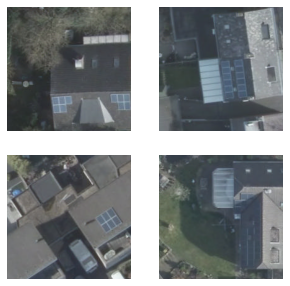

In [79]:
visualize_4neighbors(group0_data)

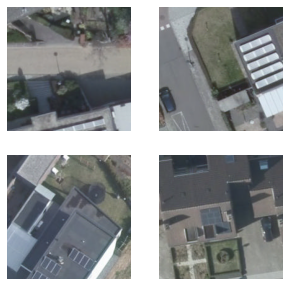

In [80]:
visualize_4neighbors(group1_data)

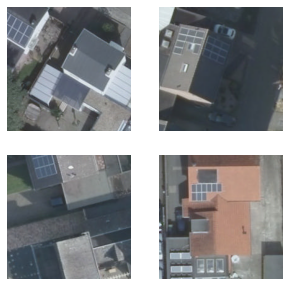

In [81]:
visualize_4neighbors(group2_data)

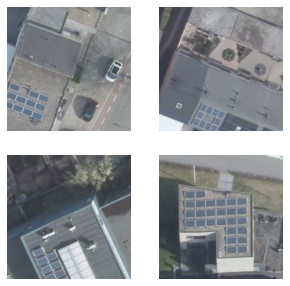

In [82]:
visualize_4neighbors(group3_data)

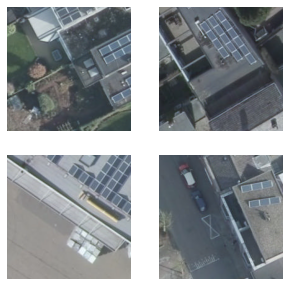

In [83]:
visualize_4neighbors(group4_data)

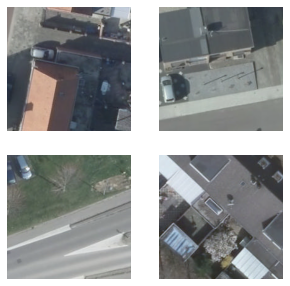

In [84]:
visualize_4neighbors(group5_data)

In [85]:
def visualize_5neighbors(group_data, start_index):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 2))
    data = group_data[start_index:start_index+5]
    for index, ax in enumerate([ax1,ax2,ax3,ax4,ax5]):
        ax.set_axis_off()
        ax.imshow(data[index]/255)

In [86]:
def visualize_multiple_samples(group_data,start_index, nr_rows):
    for i in range(nr_rows):
        visualize_5neighbors(group_data, start_index)
        start_index = start_index + 5

In [87]:
# visualize_5neighbors(group0_data, 0)

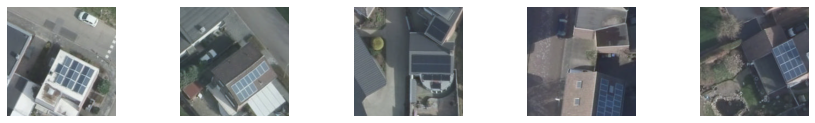

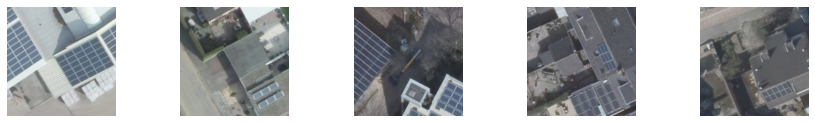

In [88]:
visualize_multiple_samples(group0_data,0, 2)

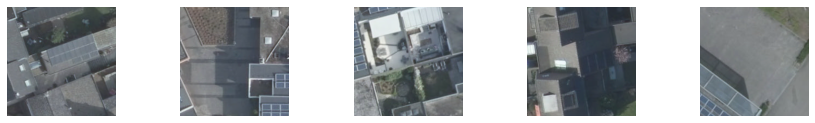

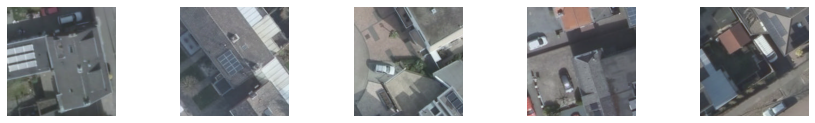

In [89]:
visualize_multiple_samples(group1_data,0, 2)

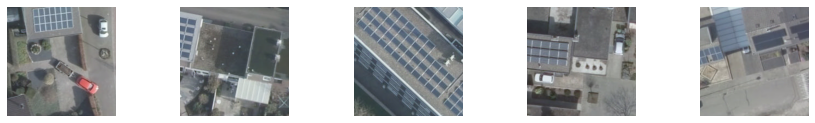

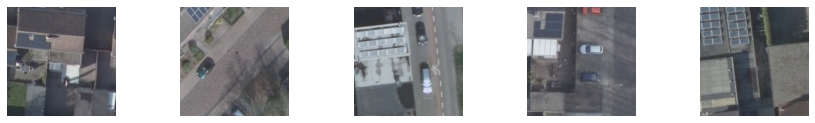

In [90]:
visualize_multiple_samples(group2_data,0, 2)

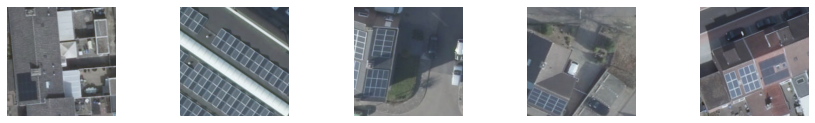

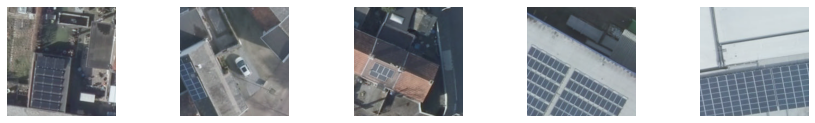

In [91]:
visualize_multiple_samples(group3_data,0, 2)

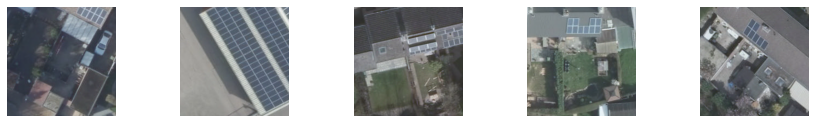

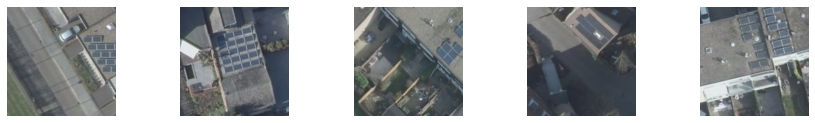

In [92]:
visualize_multiple_samples(group4_data,0, 2)

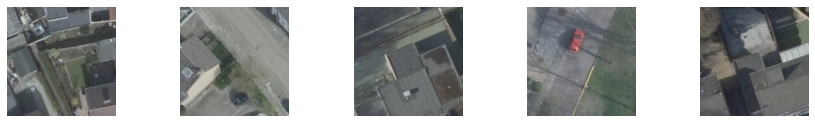

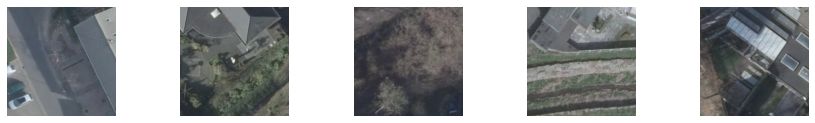

In [93]:
visualize_multiple_samples(group5_data,0, 2)

## t-SNE

In [84]:
dataindices_group0 = index_group_dict[0]
dataindices_group1 = pos_dataindices_cluster1
dataindices_group2 = index_group_dict[2]
dataindices_group3 = index_group_dict[3]
dataindices_group4 = index_group_dict[4]
dataindices_group5 = index_group_dict[5]
dataindices_group6 = neg_dataindices_cluster1

In [85]:
features_0 = []
for index, feature in zip(dataindices_group0, feature_list):
    features_0.append(feature_list[index])

features_1 = []
for index, feature in zip(dataindices_group1, feature_list):
    features_1.append(feature_list[index])

features_2 = []
for index, feature in zip(dataindices_group2, feature_list):
    features_2.append(feature_list[index])
    
features_3 = []
for index, feature in zip(dataindices_group3, feature_list):
    features_3.append(feature_list[index])
    
features_4 = []
for index, feature in zip(dataindices_group4, feature_list):
    features_4.append(feature_list[index])
    
features_5 = []
for index, feature in zip(dataindices_group5, feature_list):
    features_5.append(feature_list[index])
    
features_6 = []
for index, feature in zip(dataindices_group6, feature_list):
    features_6.append(feature_list[index])

In [86]:
from sklearn.manifold import TSNE
import seaborn as sns

In [87]:
new_km_labels = km_labels.copy()
for data_index, cluster_nr in enumerate(new_km_labels):
    if data_index in neg_dataindices_cluster1:
        new_km_labels[data_index] = 6

In [88]:
km_labels[:5]

array([1, 1, 5, 5, 4], dtype=int32)

In [89]:
new_km_labels[:5]

array([6, 6, 5, 5, 4], dtype=int32)

In [90]:
df_labels = pd.DataFrame()
df_labels['cluster_labels'] = new_km_labels
df_labels['class_labels'] = labels

In [91]:
perp = 30
n_iter = 300
features = feature_list
dataframe = df_labels
n_components = 2

In [92]:
def run_tsne(dataframe, features, perp, n_iter, n_components):
    tsne = TSNE(n_components=n_components,
               verbose=0,
               perplexity=perp,
               n_iter=n_iter,
               random_state=0,
               n_jobs=-1)
    tsne_results = tsne.fit_transform(features)
    dataframe['tsne-1'] = tsne_results[:,0]
    dataframe['tsne-2'] = tsne_results[:,1]
    return tsne_results, dataframe

In [93]:
tsne_results, df_end = run_tsne(dataframe, features, perp, n_iter,
                               n_components)


In [96]:
def create_2d_plot(dataframe):
    plt.figure(figsize=(16,10))
    scat = sns.scatterplot(
    x = 'tsne-1', y = 'tsne-2',
    hue= 'cluster_labels',
    style='class_labels',
    palette=sns.color_palette('hls', n_colors=7),
    data=dataframe,
    legend='full',
    alpha=1)

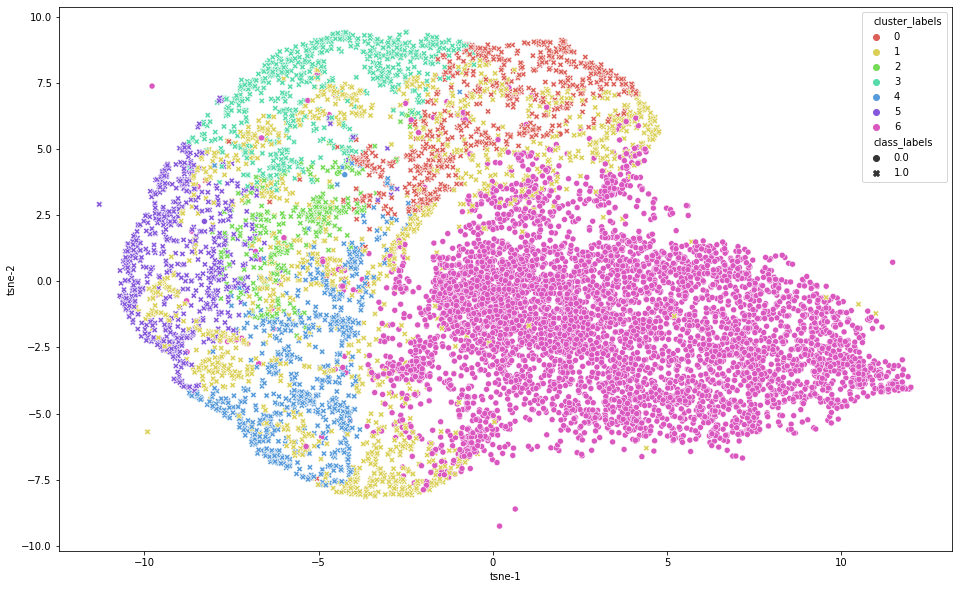

In [97]:
create_2d_plot(df_end)

#### Falsely classified samples

In [65]:
predictions = model.predict(data)
len(predictions)

10000

In [66]:
def create_classifications(predictions):
    classes = []
    for i in range(len(predictions)):
        classif = np.argmax(predictions[i])
        classes.append(classif)
    return np.array(classes)

In [67]:
test_classif = create_classifications(predictions)

In [68]:
def compute_accuracy(classification, labels):
    counter = 0
    false_classified_indices = []
    for i in range(len(classification)):
        if np.array_equal(int(classification[i]), int(labels[i])):
            counter += 1
        else:
            false_classified_indices.append(i)
    acc = counter/len(classification)
    return acc, false_classified_indices

In [69]:
accuracy, false_classified_indices = compute_accuracy(test_classif, labels)

In [70]:
accuracy

0.8893

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [72]:
print('Recall:', recall_score(labels, test_classif))
print('Precision:', precision_score(labels, test_classif))

Recall: 0.7679794520547946
Precision: 0.9936305732484076


In [73]:
conf = confusion_matrix(labels, test_classif)

In [74]:
def plot_conf_matrix(conf_matrix):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                                 display_labels=['negative', 
                                                 'positive'])
    disp.plot(values_format='d')
    plt.rcParams['figure.figsize'] = 5,5
    plt.title('Confusion matrix')

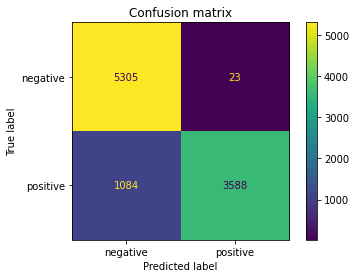

In [75]:
plot_conf_matrix(conf)

In [76]:
dataindices_group0 = index_group_dict[0]
dataindices_group1 = pos_dataindices_cluster1
dataindices_group2 = index_group_dict[2]
dataindices_group3 = index_group_dict[3]
dataindices_group4 = index_group_dict[4]
dataindices_group5 = index_group_dict[5]
dataindices_group6 = neg_dataindices_cluster1

In [77]:
def define_false_per_cluster(dataindices_group, false_indices):
    total_cluster_nr = len(dataindices_group)
    count = 0
    for index in false_indices:
        if index in dataindices_group:
            count += 1
    return count, total_cluster_nr

In [82]:
falsenr0, total_cluster_0 = define_false_per_cluster(dataindices_group0, false_classified_indices)
falsenr1, total_cluster_1 = define_false_per_cluster(dataindices_group1, false_classified_indices)
falsenr2, total_cluster_2 = define_false_per_cluster(dataindices_group2, false_classified_indices)
falsenr3, total_cluster_3 = define_false_per_cluster(dataindices_group3, false_classified_indices)
falsenr4, total_cluster_4 = define_false_per_cluster(dataindices_group4, false_classified_indices)
falsenr5, total_cluster_5 = define_false_per_cluster(dataindices_group5, false_classified_indices)
falsenr6, total_cluster_6 = define_false_per_cluster(dataindices_group6, false_classified_indices)

In [83]:
print('{} / {} = {} % is falsely classified'.format(falsenr0, total_cluster_0, falsenr0/total_cluster_0*100)) 
print('{} / {} = {} % is falsely classified'.format(falsenr1, total_cluster_1, falsenr1/total_cluster_1*100))
print('{} / {} = {} % is falsely classified'.format(falsenr2, total_cluster_2, falsenr2/total_cluster_2*100))
print('{} / {} = {} % is falsely classified'.format(falsenr3, total_cluster_3, falsenr3/total_cluster_3*100))
print('{} / {} = {} % is falsely classified'.format(falsenr4, total_cluster_4, falsenr4/total_cluster_4*100))
print('{} / {} = {} % is falsely classified'.format(falsenr5, total_cluster_5, falsenr5/total_cluster_5*100))
print('{} / {} = {} % is falsely classified'.format(falsenr6, total_cluster_6, falsenr6/total_cluster_6*100))

66 / 712 = 9.269662921348315 % is falsely classified
826 / 1599 = 51.65728580362726 % is falsely classified
12 / 330 = 3.6363636363636362 % is falsely classified
68 / 666 = 10.21021021021021 % is falsely classified
42 / 712 = 5.8988764044943816 % is falsely classified
72 / 659 = 10.925644916540213 % is falsely classified
21 / 5322 = 0.3945885005636978 % is falsely classified
